In [1]:
import skyfield
from skyfield.api import load
from skyfield.positionlib import ICRF, Astrometric, Apparent
from skyfield.positionlib import position_of_radec
from skyfield.api import T0
from skyfield.api import Star

from astropy.coordinates import SkyCoord
from astropy import units as u

import numpy as np

import pytz
from datetime import datetime, timedelta, timezone
from pytz import timezone
from tzlocal import get_localzone


import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter
import matplotlib.cm as cm
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D

utcTZ = timezone("UTC")
local_tz = get_localzone()


ts = load.timescale()
planets = load('de421.bsp')


def toUTC(d):
	if d.tzinfo is None or d.tzinfo.utcoffset(d) is None:
		d = utcTZ.normalize(utcTZ.localize(d)).astimezone(utcTZ)
	else:
		d = d.astimezone(utcTZ)
	return d

def twoObjectDistanceExplict(ra1,dec1,ra2,dec2):
	"""
	Calculate the angular distance between two coordinates.

	Parameters
	----------
	ra1 : float, array
		Right ascension of the first object in degrees.
	dec1 : float, array
		Declination of the first object in degrees.
	ra2 : float, array
		Right ascension of the second object in degrees.
	dec2 : float, array
		Declination of the second object in degrees.
	Returns
	-------
	Angle : float, array
		The angular distance in DEGREES between the first
		and second coordinate in the sky.

	"""
	delt_lon = (ra1 - ra2)*np.pi/180.
	delt_lat = (dec1 - dec2)*np.pi/180.
	# Haversine formula
	dist = 2.0*np.arcsin( np.sqrt( np.sin(delt_lat/2.0)**2 + \
		 np.cos(dec1*np.pi/180.)*np.cos(dec2*np.pi/180.)*np.sin(delt_lon/2.0)**2 ) )
	return dist/np.pi*180.

#Convert Coordinate Formats from decimal to specified format
def coordConvert(coord,format):
	if format == "HMS":
		if coord < 0:
			print("Unable to have negitive numbers with HMS format!")
			return(coord)
		return(int(coord // 15), int((coord - (coord // 15)*15) // 0.25) , (coord - (coord // 15)*15 - ((coord - (coord // 15)*15) // 0.25)*0.25)/(360/(24*60*60)))
	elif format == "DMS":
		fs = 1
		if coord < 0:
			fs = -1
			coord = abs(coord)
		return(fs*float(int(coord)), (coord - float(int(coord))) // (1/60) , (coord - float(int(coord)) - ((coord - float(int(coord))) // (1/60))*(1/60))/(1/(60*60)))
	else:
		print("Unknown format!")
		return(coord)

def coordString(coord,format):
	if format == "HMS":
		if coord < 0:
			print("Unable to have negitive numbers with HMS format!")
			return(coord)
		return f"{int(coord // 15)}h {int((coord - (coord // 15)*15) // 0.25)}m {np.around((coord - (coord // 15)*15 - ((coord - (coord // 15)*15) // 0.25)*0.25)/(360/(24*60*60)),3)}s"
	elif format == "DMS":
		fs = 1
		if coord < 0:
			fs = -1
			coord = abs(coord)
		qS = '"'
		return f"{int(fs*float(int(coord)))}$^\circ$ {int((coord - float(int(coord))) // (1/60))}' {np.around((coord - float(int(coord)) - ((coord - float(int(coord))) // (1/60))*(1/60))/(1/(60*60)),3)}{qS} "
	else:
		print("Unknown format!")
		return(coord)

{'L': [39.866165471497254, 60.795402635569225], 'S': [39.866165471497254, 60.795402635569225], 'C': [39.871157698215036, 60.77260527921786], 'C2': [39.865542460717066, 60.798247658355564], 'X': [39.872029028171625, 60.76862628935167], 'X2': [39.86815645058681, 60.78631068875698], 'X3': [39.864283873001995, 60.80399508816228], 'date': '2020-11-09 00:00:00 UTC'}


<Figure size 432x288 with 0 Axes>

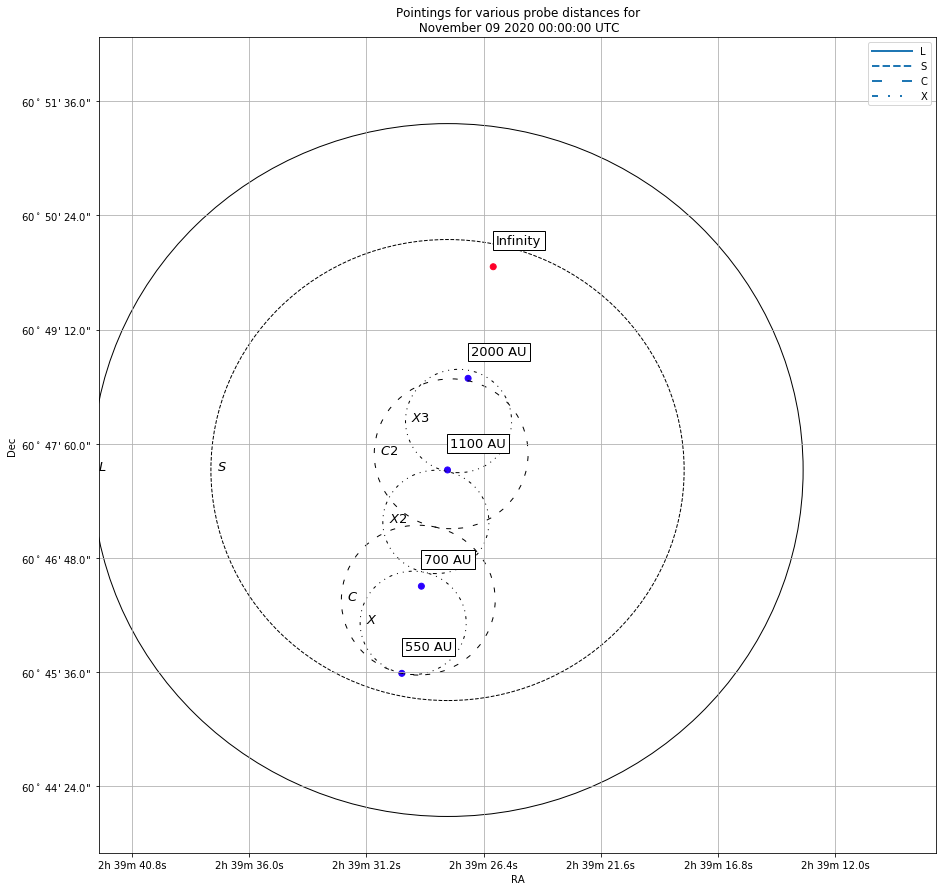

In [2]:
# This code is used to generate the plot for 1 day


def numCompare(n1,n2,eps=1):
	if abs(n1-n2) < eps:
		return True
	return False

def getLen(x1,y1,x2,y2):
	return np.sqrt( (x2 - x1)**2 + (y2 - y1)**2 )

def getMidPt(x1,y1,x2,y2):
	return [x1 + ((x2-x1)/2),y1 + ((y2-y1)/2)]

def getSegGen(x1,y1,x2,y2,dl):
	if getLen(x1,y1,x2,y2) < dl:
		yield getMidPt(x1,y1,x2,y2)
	the = 0
	the = np.arctan2(y2-y1,x2-x1)
	tL = 0
	xL = 0
	yL = 0
	while tL < getLen(x1,y1,x2,y2):
		tL += dl/2
		yL = y1 + tL*np.sin(the)
		xL = x1 + tL*np.cos(the)
		yield (xL,yL)


def getCircPts(x1,y1,x2,y2,rad):
	if getLen(x1,y1,x2,y2) < rad*2:
		return [getMidPt(x1,y1,x2,y2)]
	
	cirC = []
	prevPoint = [x1,y1]
	for p in getSegGen(x1,y1,x2,y2,rad*2):
		mdd = getMidPt(prevPoint[0],prevPoint[1],p[0],p[1])
		cirC.append(mdd)
		prevPoint = p
	
	return cirC

def buildV(ra,dec):
	x = np.cos(dec) * np.cos(ra)
	y = np.cos(dec) * np.sin(ra)
	z = np.sin(dec)
	
	return np.array([x,y,z])

#These come from my experiments to do the above with
#spherical trig

#All inputs must be in degrees!
def getLenSphere(ra1,dec1,ra2,dec2):
	ra1 = np.deg2rad(ra1)
	dec1 = np.deg2rad(dec1)
	ra2 = np.deg2rad(ra2)
	dec2 = np.deg2rad(dec2)
	
	dRA = ra2 - ra1
	dA = np.arccos(np.sin(dec1)*np.sin(dec2) + np.cos(dec1)*np.cos(dec2)*np.cos(dRA))
	
	return np.rad2deg(dA)

#All inputs must be in degrees!
def getMidPointSphere1(ra1,dec1,ra2,dec2):
	ra1 = np.deg2rad(ra1)
	dec1 = np.deg2rad(dec1)
	ra2 = np.deg2rad(ra2)
	dec2 = np.deg2rad(dec2)
	
	v1 = buildV(ra1,dec1)
	v2 = buildV(ra2,dec2)
	
	vT = v1 + (v2-v1)/2
	vT = vT/np.linalg.norm(vT)
	vI = ICRF(vT*500000).radec()
	retV = [x._degrees for x in [vI[0],vI[1]]]
	return retV

#All inputs must be in degrees!
def getMidPointSphere2(ra1,dec1,ra2,dec2):
	ra1 = np.deg2rad(ra1)
	dec1 = np.deg2rad(dec1)
	ra2 = np.deg2rad(ra2)
	dec2 = np.deg2rad(dec2)
	
	Bx = np.cos(dec2) * np.cos(ra2-ra1)
	By = np.cos(dec2) * np.sin(ra2-ra1)
	decMid = np.arctan2(np.sin(dec1) + np.sin(dec2), np.sqrt( (np.cos(dec1)+Bx)*(np.cos(dec1)+Bx) + By*By ) )
	raMid = ra1 + np.arctan2(By, np.cos(dec1) + Bx)
	
	raMid = np.rad2deg(raMid)
	decMid = np.rad2deg(decMid)
	
	return [raMid,decMid]

#Input Date
t = ts.from_datetime(datetime(2020, 11, 9, 00, 00,tzinfo=utcTZ))

sun = planets['sun']
earth = planets['earth']

#12.60/fGHz
#L-Band (1.15 – 1.73 GHz), S-Band (1.73 – 2.60 GHz), C-Band (3.95 – 8 GHz), X-Band (8.0 – 11.6 GHz)
beamLabel = ["L","S","C","X"]
upp = [1.73,2.60,8,11.6]
beams = [12.6/x for x in upp]
beamdeg =[x/60 for x in beams]
beamDict = dict(zip(beamLabel,beamdeg))

inf = 500000

onlyPlot = [550,700,1100,2000,inf]

distArr = onlyPlot

coordDict = {}

alphaCA = Star(ra_hours=(14,39,36.49400),
				dec_degrees=(-60,50,02.3737),
				ra_mas_per_year=-3679.25,
				dec_mas_per_year=473.67,
				parallax_mas=743,
				radial_km_per_s=-21.40)


for distance in distArr:
	coordDict[distance] = {}
	alphaOb = earth.at(t).observe(alphaCA)
	ra, dec, _ = alphaOb.radec()
	ra = ((ra._degrees + 180) % 360) * (24/360) 
	dec = -1*dec._degrees

	probe = position_of_radec(ra,dec,distance,t=t)
	sunPosObj = earth.at(t).observe(sun)
	inverseSunCoord = -1*sunPosObj.position.au
	probeCoord = probe.position.au
	probeDir = ICRF(probeCoord + inverseSunCoord).radec()
	coordDict[distance] = {"ra":probeDir[0]._degrees, "dec": probeDir[1]._degrees}

coordCenterDict = {}

for distance in distArr:
	mC = [coordDict[distance]['ra'],coordDict[distance]['dec']]
	coordCenterDict[distance] = {"ra":mC[0],"dec":mC[1]}

plt.clf()
fig, ax = plt.subplots(figsize=(15,15))

ax.grid()
ax.set_xlabel("RA")
ax.set_ylabel("Dec")

delX = 1/7
delY = 1/7
center = [coordCenterDict[inf]['ra'] - 1/240,coordCenterDict[inf]['dec']-1/32]

ax.set_xlim(center[0]+delX/2,center[0]-delX/2)
ax.set_ylim(center[1]-delY/2, center[1]+delY/2)


xC = []
yC = []
cP = []

mulC = 0.9/len(onlyPlot)
cPD = {}
ranCM = cm.gist_rainbow

for nC,dis in enumerate(onlyPlot):
	xC.append([])
	yC.append([])
	cP.append([])
	
	if numCompare(dis,inf):
		cPD[dis] = ranCM(0.0)
	else:
		cPD[dis] = ranCM(0.1 + mulC*nC)
	
	coor = coordDict[dis]
	if numCompare(dis,inf):
		cP[nC].append(0.0)
	else:
		cP[nC].append(0.8)
	raO =  coor['ra']
	decO = coor['dec']
	xC[nC].append(raO)
	yC[nC].append(decO)

x_ticks = [coordString(float(x),"HMS") for x in ax.get_xticks()]
y_ticks = [coordString(float(y),"DMS") for y in ax.get_yticks()]
ax.set_xticklabels(x_ticks)
ax.set_yticklabels(y_ticks)
plt.scatter(xC,yC,c=cP,cmap=cm.gist_rainbow,vmin=0,vmax=1)

for i,d in enumerate(onlyPlot):
	if d > 10000:
		dT = "Infinity"
	else:
		dT = str(d) + " AU"
	plt.text(coordCenterDict[d]['ra']-0.0005,coordCenterDict[d]['dec']+0.004,dT,fontsize=13,fontweight='book',bbox=dict(facecolor='white', edgecolor='black', pad=3.0))

beamOrder = []
beamCenter = []

distLBeams = {"L":[550,inf],"S":[550,inf],"C":[550,inf],"X":[550,inf]}
maxNBeams = {"L":1,"S":1,"C":2,"X":3}
nBeams = {"L":0,"S":0,"C":0,"X":0}

for beamL,beamD in beamDict.items():
	lL = distLBeams[beamL][0]
	uL = distLBeams[beamL][1]
	
	cX1 = coordCenterDict[lL]['ra'].copy()
	cY1 = coordCenterDict[lL]['dec'].copy()
	cX2 = coordCenterDict[uL]['ra'].copy()
	cY2 = coordCenterDict[uL]['dec'].copy()
	
	rr = beamD
	beamCs = getCircPts(cX1,cY1,cX2,cY2,rr)
	for beamCC in beamCs:
		nBeams[beamL] += 1
		if nBeams[beamL] > maxNBeams[beamL]:
			break
		beamOrder.append(beamL)
		beamCenter.append(beamCC)

beamLineStyle = {"L":"-","S":"--","C":(0, (5, 10)),"X":(0, (3, 5, 1, 5, 1, 5))}

beamTextt = []
found = {}
for k in beamOrder:
	try:
		found[k] += 1
	except KeyError:
		found[k] = 1
	if found[k] == 1:
		beamTextt.append(k)
	else:
		beamTextt.append(k+str(found[k]))

for i,b in enumerate(beamOrder):
	beamdeg = beamDict[b]
	cirCen = beamCenter[i]
	ax.add_patch(Circle(cirCen,beamdeg/2,fill=None,ls=beamLineStyle[b]))
	plt.text(cirCen[0]+beamdeg/2-0.001,cirCen[1],"$\it{" + beamTextt[i] + "}$",fontsize=13)

ax.set_title("Pointings for various probe distances for\n " + t.utc_datetime().strftime('%B %d %Y %H:%M:%S %Z'))

legend_elements = []
for beamN, beamLS in beamLineStyle.items():
	legend_elements.append(Line2D([0], [0], lw=2, linestyle=beamLS, label=beamN))

ax.legend(handles=legend_elements, loc=1,handlelength=4)

beamReturn = dict(zip(beamTextt,beamCenter))
beamReturn['date'] = t.utc_datetime().strftime('%Y-%m-%d %H:%M:%S %Z')
print(beamReturn)

plt.savefig("pointingPNG.png")

<Figure size 432x288 with 0 Axes>

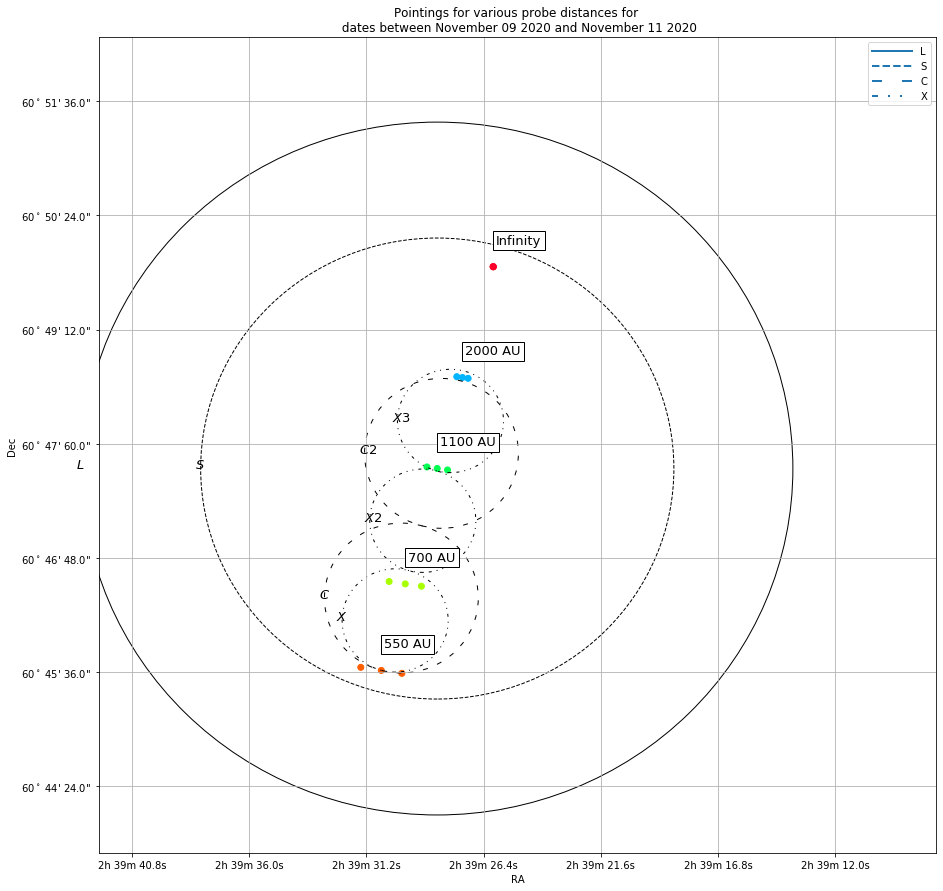

In [3]:
# This code is used to generate the plot for multiple days


def numCompare(n1,n2,eps=1):
	if abs(n1-n2) < eps:
		return True
	return False

def getLen(x1,y1,x2,y2):
	return np.sqrt( (x2 - x1)**2 + (y2 - y1)**2 )

def getMidPt(x1,y1,x2,y2):
	return [x1 + ((x2-x1)/2),y1 + ((y2-y1)/2)]

def getSegGen(x1,y1,x2,y2,dl):
	if getLen(x1,y1,x2,y2) < dl:
		yield getMidPt(x1,y1,x2,y2)
	the = 0
	the = np.arctan2(y2-y1,x2-x1)
	tL = 0
	xL = 0
	yL = 0
	while tL < getLen(x1,y1,x2,y2):
		tL += dl/2
		yL = y1 + tL*np.sin(the)
		xL = x1 + tL*np.cos(the)
		yield (xL,yL)


def getCircPts(x1,y1,x2,y2,rad):
	if getLen(x1,y1,x2,y2) < rad*2:
		return [getMidPt(x1,y1,x2,y2)]
	
	cirC = []
	prevPoint = [x1,y1]
	for p in getSegGen(x1,y1,x2,y2,rad*2):
		mdd = getMidPt(prevPoint[0],prevPoint[1],p[0],p[1])
		cirC.append(mdd)
		prevPoint = p
	
	return cirC

def buildV(ra,dec):
	x = np.cos(dec) * np.cos(ra)
	y = np.cos(dec) * np.sin(ra)
	z = np.sin(dec)
	
	return np.array([x,y,z])

#All inputs must be in degrees!
def getMidPointSphere1(ra1,dec1,ra2,dec2):
	ra1 = np.deg2rad(ra1)
	dec1 = np.deg2rad(dec1)
	ra2 = np.deg2rad(ra2)
	dec2 = np.deg2rad(dec2)
	
	v1 = buildV(ra1,dec1)
	v2 = buildV(ra2,dec2)
	
	vT = v1 + (v2-v1)/2
	vT = vT/np.linalg.norm(vT)
	vI = ICRF(vT*500000).radec()
	retV = [x._degrees for x in [vI[0],vI[1]]]
	return retV

#All inputs must be in degrees!
def getMidPointSphere2(ra1,dec1,ra2,dec2):
	ra1 = np.deg2rad(ra1)
	dec1 = np.deg2rad(dec1)
	ra2 = np.deg2rad(ra2)
	dec2 = np.deg2rad(dec2)
	
	Bx = np.cos(dec2) * np.cos(ra2-ra1)
	By = np.cos(dec2) * np.sin(ra2-ra1)
	decMid = np.arctan2(np.sin(dec1) + np.sin(dec2), np.sqrt( (np.cos(dec1)+Bx)*(np.cos(dec1)+Bx) + By*By ) )
	raMid = ra1 + np.arctan2(By, np.cos(dec1) + Bx)
	
	raMid = np.rad2deg(raMid)
	decMid = np.rad2deg(decMid)
	
	return [raMid,decMid]

sun = planets['sun']
earth = planets['earth']

#Input Date, number of days to calculate
startDay = datetime(2020, 11, 9, 00, 00,tzinfo=utcTZ)
maxDays = 3

#12.60/fGHz
#L-Band (1.15 – 1.73 GHz), S-Band (1.73 – 2.60 GHz), C-Band (3.95 – 8 GHz), X-Band (8.0 – 11.6 GHz)
beamLabel = ["L","S","C","X"]
upp = [1.73,2.60,8,11.6]
beams = [12.6/x for x in upp]
beamdeg =[x/60 for x in beams]
beamDict = dict(zip(beamLabel,beamdeg))

inf = 500000

onlyPlot = [550,700,1100,2000,inf]

distArr = onlyPlot

coordDict = {}

alphaCA = Star(ra_hours=(14,39,36.49400),
				dec_degrees=(-60,50,02.3737),
				ra_mas_per_year=-3679.25,
				dec_mas_per_year=473.67,
				parallax_mas=743,
				radial_km_per_s=-21.40)


for distance in distArr:
	coordDict[distance] = {}
	for dayNum in range(maxDays):
		t = ts.from_datetime(startDay + timedelta(days=dayNum))
		alphaOb = earth.at(t).observe(alphaCA)
		ra, dec, _ = alphaOb.radec()
		ra = ((ra._degrees + 180) % 360) * (24/360) 
		dec = -1*dec._degrees
		
		probe = position_of_radec(ra,dec,distance,t=t)
		sunPosObj = earth.at(t).observe(sun)
		inverseSunCoord = -1*sunPosObj.position.au
		probeCoord = probe.position.au
		probeDir = ICRF(probeCoord + inverseSunCoord).radec()
		coordDict[distance][dayNum] = {"ra":probeDir[0]._degrees, "dec": probeDir[1]._degrees}

coordCenterDict = {}

dayL = list(range(maxDays))
firstDay = dayL[0]
lastDay = dayL[-1]

for distance in distArr:
	fC = coordDict[distance][firstDay]
	lC = coordDict[distance][lastDay]
	mC = getMidPointSphere2(fC['ra'],fC['dec'],lC['ra'],lC['dec'])
	coordCenterDict[distance] = {"ra":mC[0],"dec":mC[1]}

plt.clf()
fig, ax = plt.subplots(figsize=(15,15))

ax.grid()
ax.set_xlabel("RA")
ax.set_ylabel("Dec")

delX = 1/7
delY = 1/7
center = [coordCenterDict[inf]['ra'] - 1/240,coordCenterDict[inf]['dec']-1/32]

ax.set_xlim(center[0]+delX/2,center[0]-delX/2)
ax.set_ylim(center[1]-delY/2, center[1]+delY/2)

#pX1 = coordDict[np.min(onlyPlot)]['ra'].copy()
#pY1 = coordDict[np.min(onlyPlot)]['dec'].copy()
#pX2 = coordDict[np.max(onlyPlot)]['ra'].copy()
#pY2 = coordDict[np.max(onlyPlot)]['dec'].copy()

#ax.plot([pX1,pX2],[pY1,pY2])


xC = []
yC = []
cP = []

mulC = 0.9/len(onlyPlot)
cPD = {}
ranCM = cm.gist_rainbow

for nC,dis in enumerate(onlyPlot):
	xC.append([])
	yC.append([])
	cP.append([])
	
	if numCompare(dis,inf):
		cPD[dis] = ranCM(0.0)
	else:
		cPD[dis] = ranCM(0.1 + mulC*nC)
	
	for dayNum in range(maxDays):
		coor = coordDict[dis][dayNum]
		if numCompare(dis,inf):
			cP[nC].append(0.0)
		else:
			cP[nC].append(0.1 + mulC*nC)
		raO =  coor['ra']
		decO = coor['dec']
		xC[nC].append(raO)
		yC[nC].append(decO)

x_ticks = [coordString(float(x),"HMS") for x in ax.get_xticks()]
y_ticks = [coordString(float(y),"DMS") for y in ax.get_yticks()]
ax.set_xticklabels(x_ticks)
ax.set_yticklabels(y_ticks)
plt.scatter(xC,yC,c=cP,cmap=cm.gist_rainbow,vmin=0,vmax=1)

for i,d in enumerate(onlyPlot):
	if d > 10000:
		dT = "Infinity"
	else:
		dT = str(d) + " AU"
	plt.text(coordCenterDict[d]['ra']-0.0005,coordCenterDict[d]['dec']+0.004,dT,fontsize=13,fontweight='book',bbox=dict(facecolor='white', edgecolor='black', pad=3.0))

beamOrder = []
beamCenter = []

distLBeams = {"L":[550,inf],"S":[550,inf],"C":[550,inf],"X":[550,inf]}
maxNBeams = {"L":1,"S":1,"C":2,"X":3}
nBeams = {"L":0,"S":0,"C":0,"X":0}

for beamL,beamD in beamDict.items():
	lL = distLBeams[beamL][0]
	uL = distLBeams[beamL][1]
	
	cX1 = coordCenterDict[lL]['ra'].copy()
	cY1 = coordCenterDict[lL]['dec'].copy()
	cX2 = coordCenterDict[uL]['ra'].copy()
	cY2 = coordCenterDict[uL]['dec'].copy()
	
	rr = beamD
	beamCs = getCircPts(cX1,cY1,cX2,cY2,rr)
	for beamCC in beamCs:
		nBeams[beamL] += 1
		if nBeams[beamL] > maxNBeams[beamL]:
			break
		beamOrder.append(beamL)
		beamCenter.append(beamCC)

beamLineStyle = {"L":"-","S":"--","C":(0, (5, 10)),"X":(0, (3, 5, 1, 5, 1, 5))}


beamTextt = []
found = {}
for k in beamOrder:
	try:
		found[k] += 1
	except KeyError:
		found[k] = 1
	if found[k] == 1:
		beamTextt.append(k)
	else:
		beamTextt.append(k+str(found[k]))

for i,b in enumerate(beamOrder):
	beamdeg = beamDict[b]
	cirCen = beamCenter[i]
	ax.add_patch(Circle(cirCen,beamdeg/2,fill=None,ls=beamLineStyle[b]))
	plt.text(cirCen[0]+beamdeg/2+0.001,cirCen[1],"$\it{" + beamTextt[i] + "}$",fontsize=13)

ax.set_title("Pointings for various probe distances for \n dates between " + ts.from_datetime(startDay).utc_strftime('%B %d %Y') + " and " + ts.from_datetime(startDay + timedelta(days=maxDays-1)).utc_strftime('%B %d %Y'))

legend_elements = []
for beamN, beamLS in beamLineStyle.items():
	legend_elements.append(Line2D([0], [0], lw=2, linestyle=beamLS, label=beamN))

ax.legend(handles=legend_elements, loc=1,handlelength=4)

plt.savefig("pointingPNG.png")